<a href="https://colab.research.google.com/github/AHamamd150/ML_Course_BUE/blob/main/BUE_2024/codes/Lecture_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we show how to use the CNN to analyze the Fashion mnist dataset. Also, it shows how to use interpretable AI method called Grad-CAM to understand the model decision making. Original Grad-CAM paper is here, https://arxiv.org/pdf/1610.02391


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.datasets import  fashion_mnist

In [4]:
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

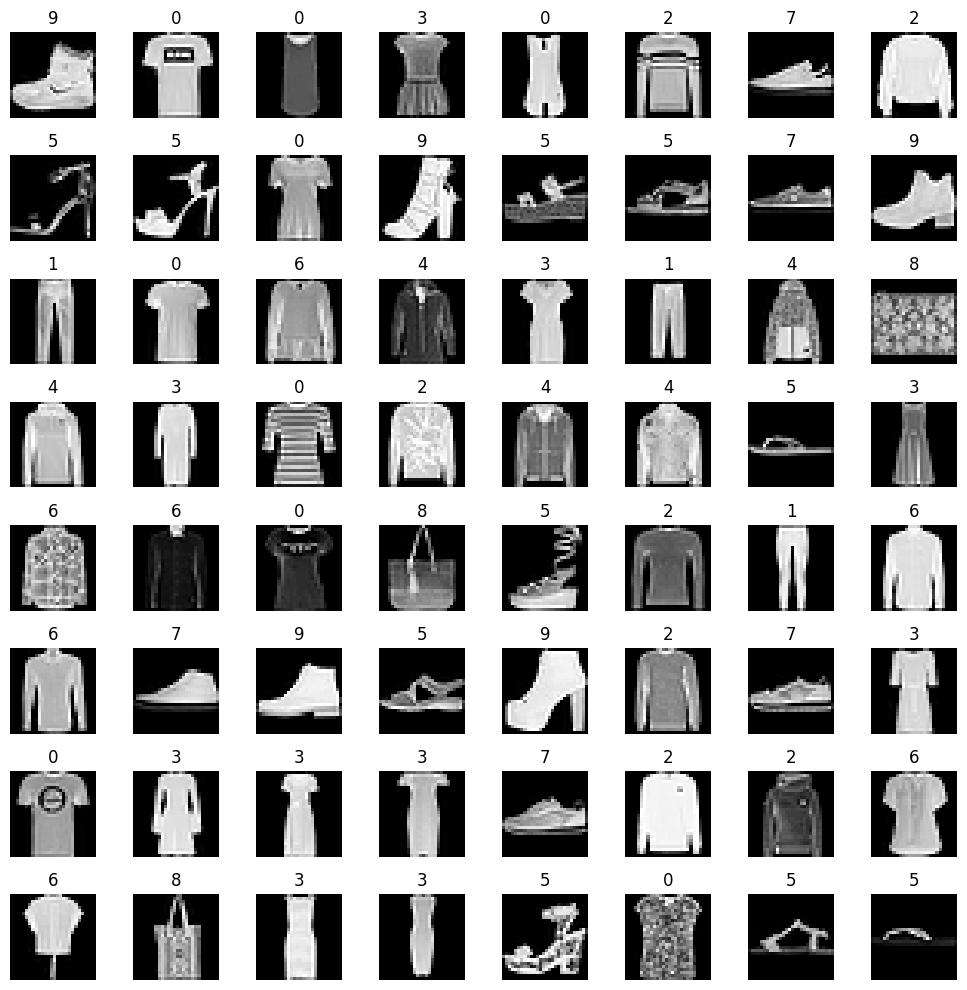

In [63]:
fig = plt.figure(figsize=(10,10))
for q in range(64):
    fig.add_subplot(8,8,q+1)
    plt.imshow(x_train[q],cmap='gray');
    plt.title(y_train[q])
    plt.axis('off')
plt.tight_layout()

# Reshape the inputs to fi thte CNN **structure**

In [15]:
x_train = tf.expand_dims(x_train,axis=-1)
x_test = tf.expand_dims(x_test,axis=-1)
print(f'Dimensions of the training data=  {x_train.shape}')
print(f'Dimensions of the test data=  {x_test.shape}')

Dimensions of the training data=  (60000, 28, 28, 1)
Dimensions of the test data=  (10000, 28, 28, 1)


# Construct the CNN network

In [47]:
inp =keras.layers.Input((28,28,1))
e = keras.layers.Conv2D(16, (3, 3), activation='relu',name = 'Conv_1')(inp)
e = keras.layers.Conv2D(16, (3, 3), activation='relu',name = 'Conv_2')(e)
e = keras.layers.MaxPooling2D((2, 2),name = 'Pooling_1')(e)
#e=  keras.layers.Dropout(0.2)(e)
e = keras.layers.Conv2D(32, (3, 3), activation='relu',name = 'Conv_3')(e)
e = keras.layers.Conv2D(32, (3, 3), activation='relu',name = 'Conv_4')(e)
e = keras.layers.MaxPooling2D((2, 2),name = 'Pooling_2')(e)
#e=  keras.layers.Dropout(0.2)(e)
e = keras.layers.Flatten()(e)
e = keras.layers.Dense(128, activation='relu',name = 'FC_1')(e)
e=  keras.layers.Dropout(0.2)(e)
x=  keras.layers.Dense(10, activation="softmax")(e)
cnn = keras.Model(inp,x)
cnn.summary()

Model: "model_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Conv_1 (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 Conv_2 (Conv2D)             (None, 24, 24, 16)        2320      
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 12, 12, 16)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 10, 10, 32)        4640      
                                                                 
 Conv_4 (Conv2D)             (None, 8, 8, 32)          9248      
                                                                 
 Pooling_2 (MaxPooling2D)    (None, 4, 4, 32)          0 

#Train the network

In [48]:
cnn.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])
history_cnn = cnn.fit(x_train, y_train, validation_split=0.15, epochs=10, batch_size=128,shuffle=False, verbose=1)


Epoch 1/10
399/399 [==============================] - 3s 6ms/step - loss: 0.6938 - accuracy: 0.7424 - val_loss: 0.4848 - val_accuracy: 0.8200
Epoch 2/10
399/399 [==============================] - 2s 5ms/step - loss: 0.4371 - accuracy: 0.8392 - val_loss: 0.4047 - val_accuracy: 0.8494
Epoch 3/10
399/399 [==============================] - 2s 5ms/step - loss: 0.3723 - accuracy: 0.8629 - val_loss: 0.3404 - val_accuracy: 0.8696
Epoch 4/10
399/399 [==============================] - 3s 6ms/step - loss: 0.3358 - accuracy: 0.8768 - val_loss: 0.3122 - val_accuracy: 0.8818
Epoch 5/10
399/399 [==============================] - 2s 5ms/step - loss: 0.3091 - accuracy: 0.8859 - val_loss: 0.2899 - val_accuracy: 0.8919
Epoch 6/10
399/399 [==============================] - 2s 5ms/step - loss: 0.2848 - accuracy: 0.8944 - val_loss: 0.2737 - val_accuracy: 0.8988
Epoch 7/10
399/399 [==============================] - 2s 5ms/step - loss: 0.2673 - accuracy: 0.9017 - val_loss: 0.2673 - val_accuracy: 0.9014
Epoch 

# Plot the network predictions

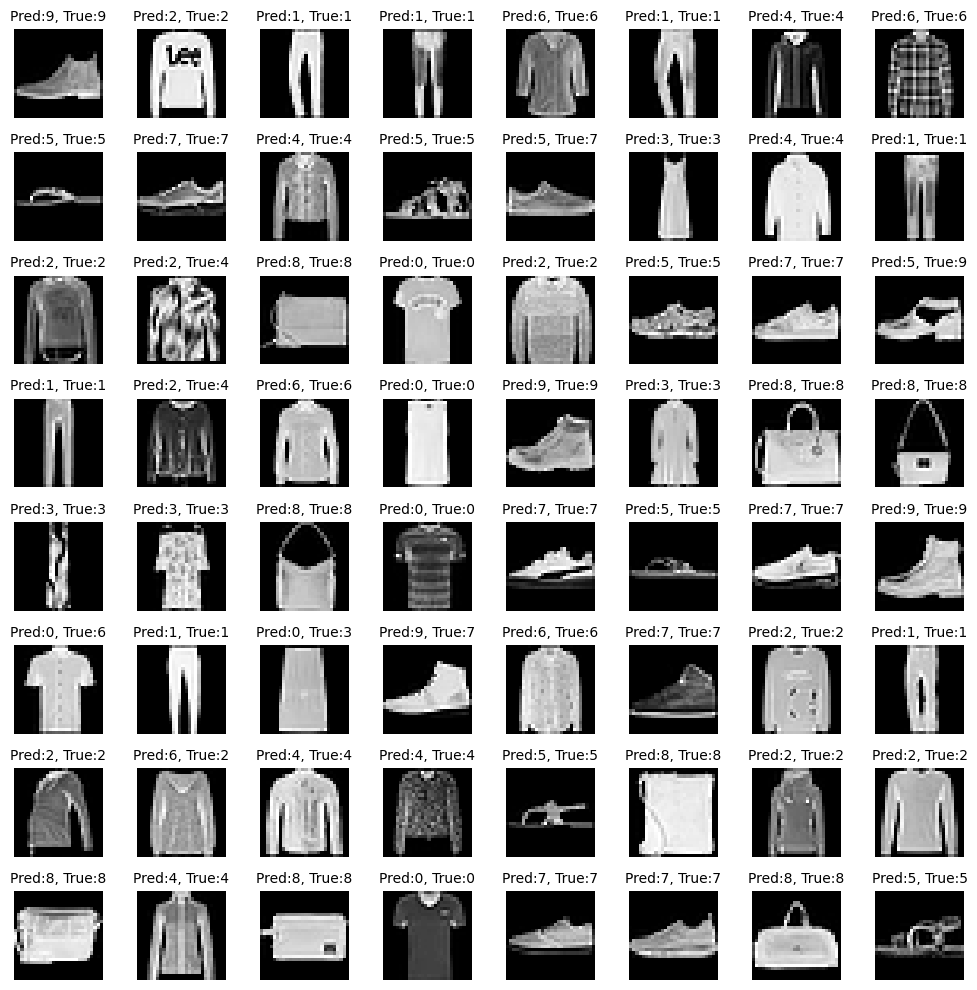

In [62]:
##### Do some predictions ####
fig = plt.figure(figsize=(10,10))
for q in range(64):
    fig.add_subplot(8,8,q+1)
    plt.imshow(x_test[q],cmap='gray');
    x1= cnn.predict(np.expand_dims(x_test[q],0),verbose=0)
    plt.title('Pred:'+str(np.argmax(x1))+', True:'+str(y_test[q]),fontsize=10)
    plt.axis('off')
plt.tight_layout()

# Grad-Cam for interpetability


In [50]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils
import cv2

In [51]:
### This is not my original code!! I adjusted it from earlier code ###
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = keras.Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        #heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        #output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [60]:
def plot_img(img):
    image = tf.reshape(img,(-1,28,28,1))
    preds = cnn.predict(image,verbose=0)
    i = np.argmax(preds)
    cam = GradCAM(cnn, i)
    heatmap = cam.compute_heatmap(image)
    heatmap = heatmap/(heatmap.max()+1e-07)
    output = cv2.addWeighted(img.numpy().astype('float64'), 0.8, heatmap,0.5, 0)
    output_stack = np.vstack([output,heatmap])
    return output,output_stack


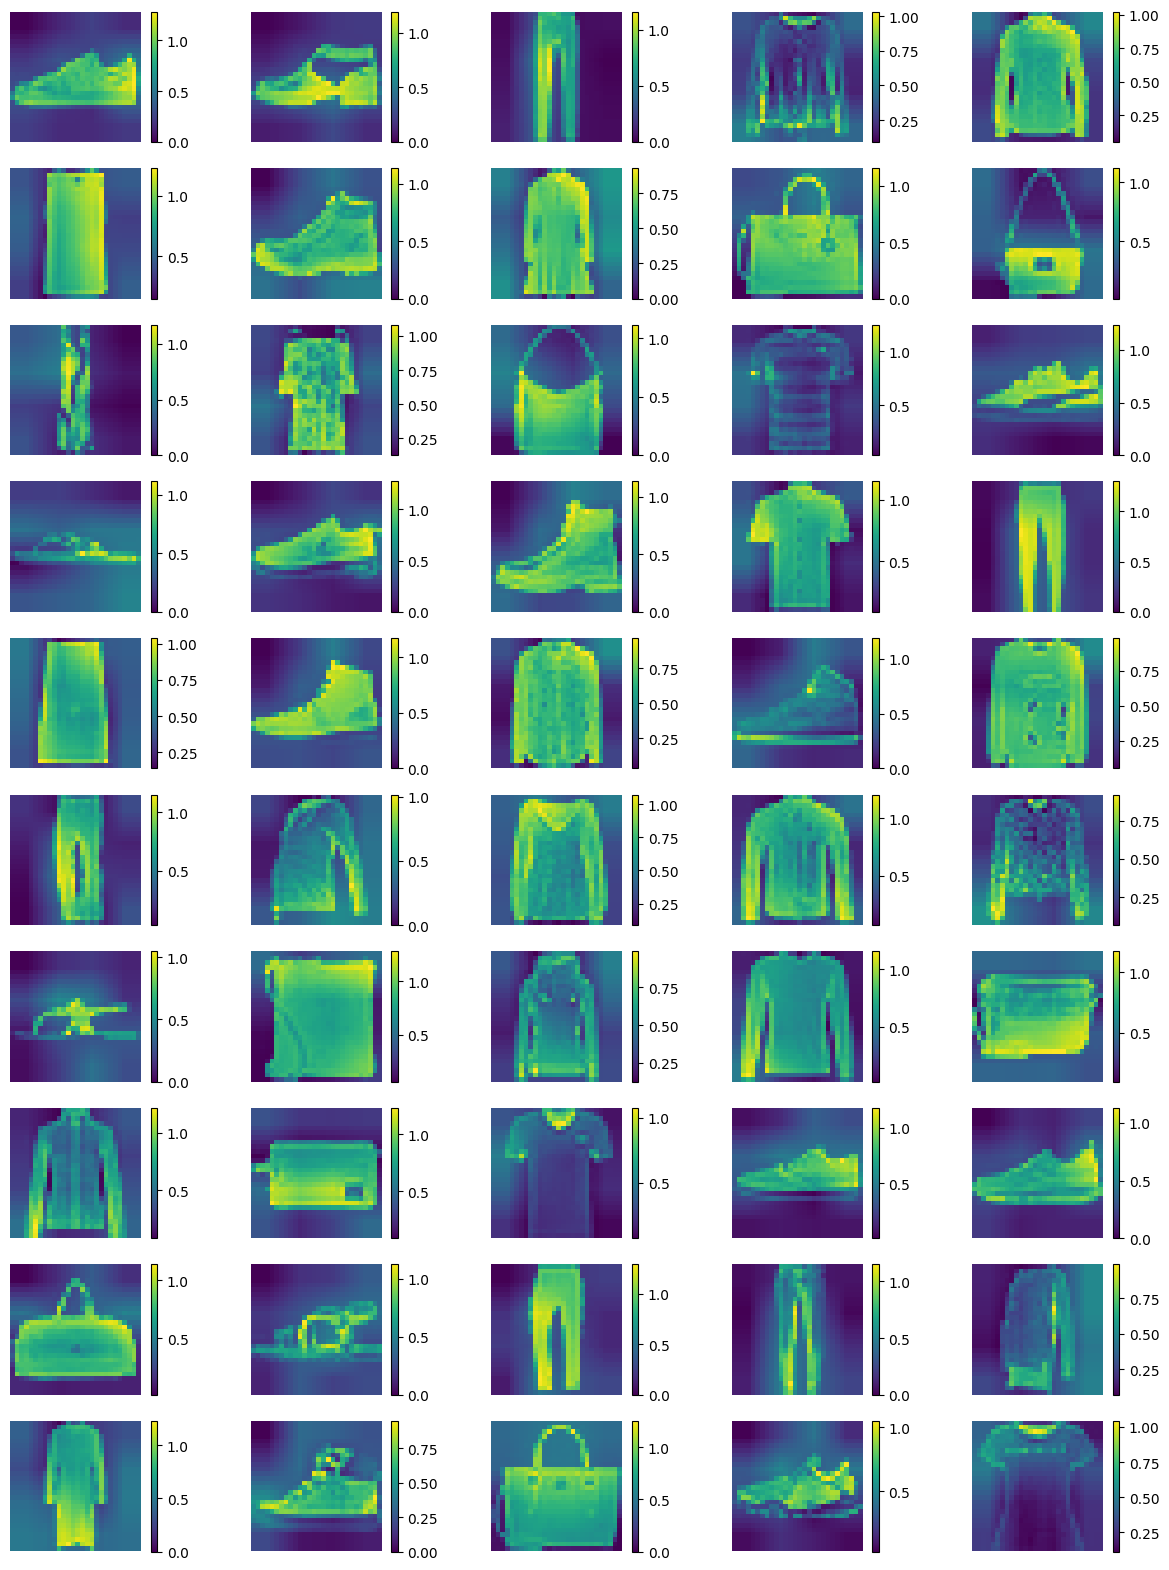

In [61]:
fig = plt.figure(figsize=(15,20))
for q in range(50):
    fig.add_subplot(10,5,q+1)
    out,_ = plot_img(x_test[22+q])
    plt.imshow(out);
    plt.colorbar();
    plt.axis('off')

The plot highlights where are the regions in the images that teh network uses to make the classification. Please read the Grad-CAM paper for better understandig